In [ ]:
#!pip install python-dotenv huggingface_hub datasets matplotlib transformers scikit-learn numpy gensim

In [3]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# environment
load_dotenv(override=True)

# Get the HF token from environment variables
hf_token = os.getenv('HF_TOKEN')

# Log in to Hugging Face
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
# Load in our dataset
rawdata = load_dataset("cogsci13/Amazon-Reviews-2023-Books-Meta", split="full", trust_remote_code=True)
#print(dataset[0])


# Data Exploration

In [4]:
len(rawdata)

4448181

In [5]:
print(rawdata[0])

{'main_category': 'Books', 'title': 'Chaucer', 'average_rating': 4.5, 'rating_number': 29, 'features': [], 'description': [], 'price': '8.23', 'images': {'hi_res': [None], 'large': ['https://m.media-amazon.com/images/I/41X61VPJYKL._SX334_BO1,204,203,200_.jpg'], 'thumb': [None], 'variant': ['MAIN']}, 'videos': {'title': [], 'url': [], 'user_id': []}, 'store': 'Peter Ackroyd (Author)', 'categories': ['Books', 'Literature & Fiction', 'History & Criticism'], 'details': '{"Publisher": "Chatto & Windus; First Edition (January 1, 2004)", "Language": "English", "Hardcover": "196 pages", "ISBN 10": "0701169850", "ISBN 13": "978-0701169855", "Item Weight": "10.1 ounces", "Dimensions": "5.39 x 0.71 x 7.48 inches"}', 'parent_asin': '0701169850', 'bought_together': None, 'subtitle': 'Hardcover – Import, January 1, 2004', 'author': "{'avatar': 'https://m.media-amazon.com/images/I/21Je2zja9pL._SY600_.jpg', 'name': 'Peter Ackroyd', 'about': ['Peter Ackroyd, (born 5 October 1949) is an English biograph

In [6]:
# Investigate a particular datapoint
datapoint = rawdata[1]
datapoint

{'main_category': 'Books',
 'title': 'Notes from a Kidwatcher',
 'average_rating': 5.0,
 'rating_number': 1,
 'features': ["Contains 23 selected articles by this influential writer, researcher, educator, and speaker. They're grouped around six major themes inherent in teacher education: culture and community; miscue analysis, reading strategies and comprehension; print awareness and the roots of literacy; the writing process; kidwatching; and whole language theory. No index. Annotation c. by Book News, Inc., Portland, Or."],
 'description': ['About the Author',
  "SANDRA WILDE, Ph.D., is widely recognized for her expertise in developmental spelling and her advocacy of holistic approaches to spelling and phonics. She is Professor of Curriculum and Instruction at Portland State University in Oregon. She is best known for her work in invented spelling, phonics and miscue analysis. She specializes in showing teachers how kids' invented spellings and miscues can help us work with them in mo

In [39]:
# Investigate
datapoint = rawdata[5]
print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Writings from a Black Woman Living in the Land of the "Free": Strength, Power, Resilience
[]
["Take a step into the modern perspective of a young black woman living in America. Tori Ruff explores the injustices and pain endured by the African American community for centuries. Through a series of writings, she speaks on topics including police brutality, racism, and discrimination. 'Writings from a Black Woman Living in the Land of the Free' takes readers on a journey of empathy and a sense of empowerment."]
{"Publisher": "Independently published (December 30, 2021)", "Language": "English", "Paperback": "24 pages", "ISBN 13": "979-8528537702", "Item Weight": "3.2 ounces", "Dimensions": "7 x 0.06 x 9 inches"}
4.05


In [7]:
# How many have prices?

prices = 0
for datapoint in rawdata:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(rawdata)*100:,.1f}%")

There are 3,286,798 with prices which is 73.9%


In [6]:
#Filter only records with prices

filtered = (dp for dp in rawdata if "price" in dp and isinstance(dp["price"], str) and dp["price"].replace('.', '', 1).isdigit() and float(dp["price"]) > 0)


In [7]:
# Convert a sample of filtered data to in-memory dataset
sampled_data = []
for i, dp in enumerate(filtered):
    if i >= 100000:  # pick a reasonable sample size, e.g. 10k
        break
    sampled_data.append(dp)

dataset = Dataset.from_list(sampled_data)
print(f"Loaded {len(dataset):,} examples with prices.")

Loaded 100,000 examples with prices.


In [8]:
prices = []
lengths = []

for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = (
                datapoint["title"] +
                str(datapoint.get("description", "")) +
                str(datapoint.get("features", "")) +
                str(datapoint.get("details", ""))
            )
            lengths.append(len(contents))
    except ValueError:
        pass

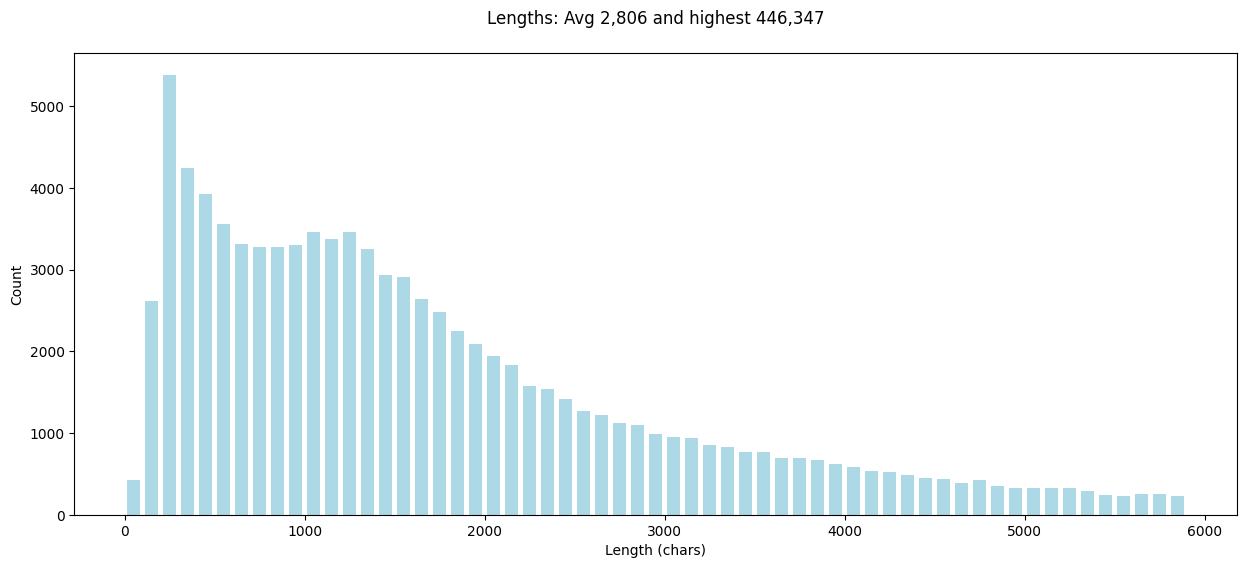

In [25]:
# Plot lengths
plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

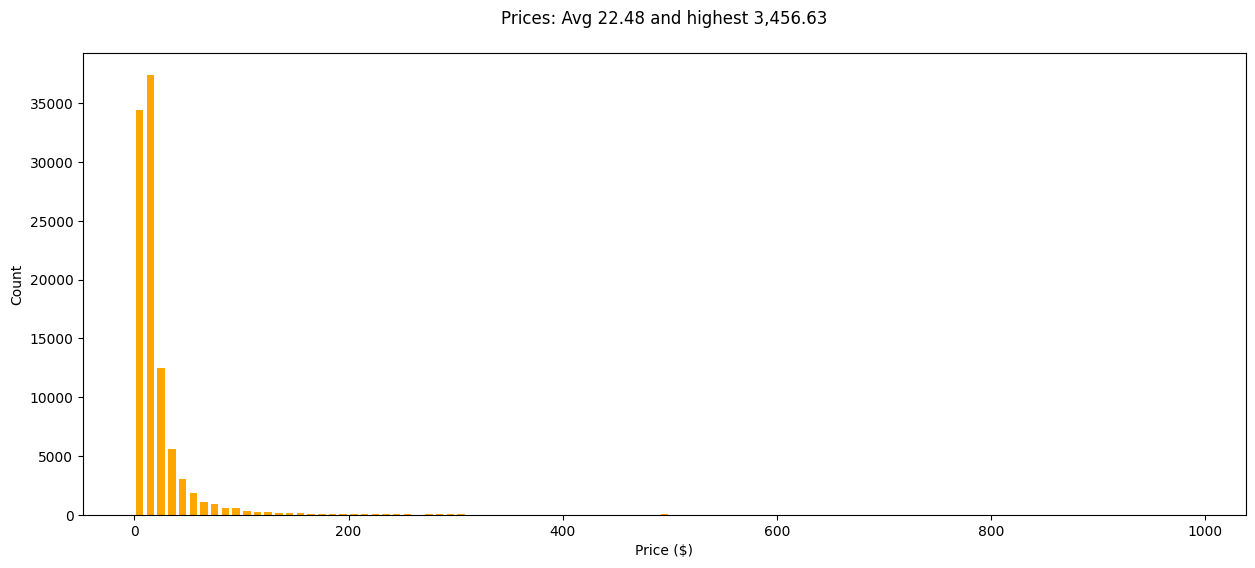

In [26]:
# Plot prices
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [ ]:
# So what is this book??

for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 3400:
            print(datapoint['title'])
    except ValueError as e:
        pass

More harvest festival dramas of Tibet,


# Data Transform

In [2]:
from transformers import AutoTokenizer
import re

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
MIN_TOKENS = 150  # Any less than this, and we don't have enough useful content
MAX_TOKENS = 160  # Truncate after this many tokens
MIN_CHARS = 300
CEILING_CHARS = MAX_TOKENS * 7

In [9]:
def clean_text(text: str) -> str:
    # Remove unnecessary characters
    text = re.sub(r'[:\[\]"{}【】\s]+', ' ', text).strip()
    text = text.replace(" ,", ",").replace(",,,",",").replace(",,",",")
    words = text.split(' ')
    # Remove likely product codes
    select = [word for word in words if len(word) < 7 or not any(char.isdigit() for char in word)]
    return " ".join(select)

In [10]:
text = 'Writings from a Black Woman Living in the Land of the "Free": Strength, Power, Resilience'
cleaned = clean_text(text)
print(cleaned)


Writings from a Black Woman Living in the Land of the Free Strength, Power, Resilience


In [ ]:
# BookItems.py

In [6]:
from BookItems import BookItem

In [12]:
book_items = []
for datapoint in dataset:  
    try:
        price = float(datapoint["price"])  
        book_item = BookItem(datapoint, price)
        if book_item.include:
            book_items.append(book_item)
    except (ValueError, TypeError):
        pass  # Skip if any unexpected error still shows up


In [ ]:
print(f"There are {len(book_items):,} books")

There are 85,032 books


In [15]:
book_items[0]

<Chaucer = $8.23>

In [17]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(book_items[8000].prompt)

How much does this book cost to the nearest dollar?

George Ferris, What a Wheel! (Penguin Core Concepts)
About the Author Barbara Lowell lives in Tulsa, Oklahoma, a long way from the world's tallest Ferris wheel, the Singapore Flyer. Have you ever ridden a Ferris wheel? You go up, up, up and can see for miles! But when the inventor of the Ferris wheel, George Ferris, first pitched the idea, everyone thought he was crazy. A bicycle wheel that goes around and around and carries people in train cars? Can't be done, they said. But George proved them wrong. Read about how George's hard work, courage, and imagination created one of the most famous fair rides today. George Ferris, What a Wheel covers the concepts Imagination and Problem Solving. Publisher Grosset

Price is $8.00


In [24]:
print(book_items[8000].test_prompt())

How much does this book cost to the nearest dollar?

George Ferris, What a Wheel! (Penguin Core Concepts)
About the Author Barbara Lowell lives in Tulsa, Oklahoma, a long way from the world's tallest Ferris wheel, the Singapore Flyer. Have you ever ridden a Ferris wheel? You go up, up, up and can see for miles! But when the inventor of the Ferris wheel, George Ferris, first pitched the idea, everyone thought he was crazy. A bicycle wheel that goes around and around and carries people in train cars? Can't be done, they said. But George proved them wrong. Read about how George's hard work, courage, and imagination created one of the most famous fair rides today. George Ferris, What a Wheel covers the concepts Imagination and Problem Solving. Publisher Grosset

Price is $


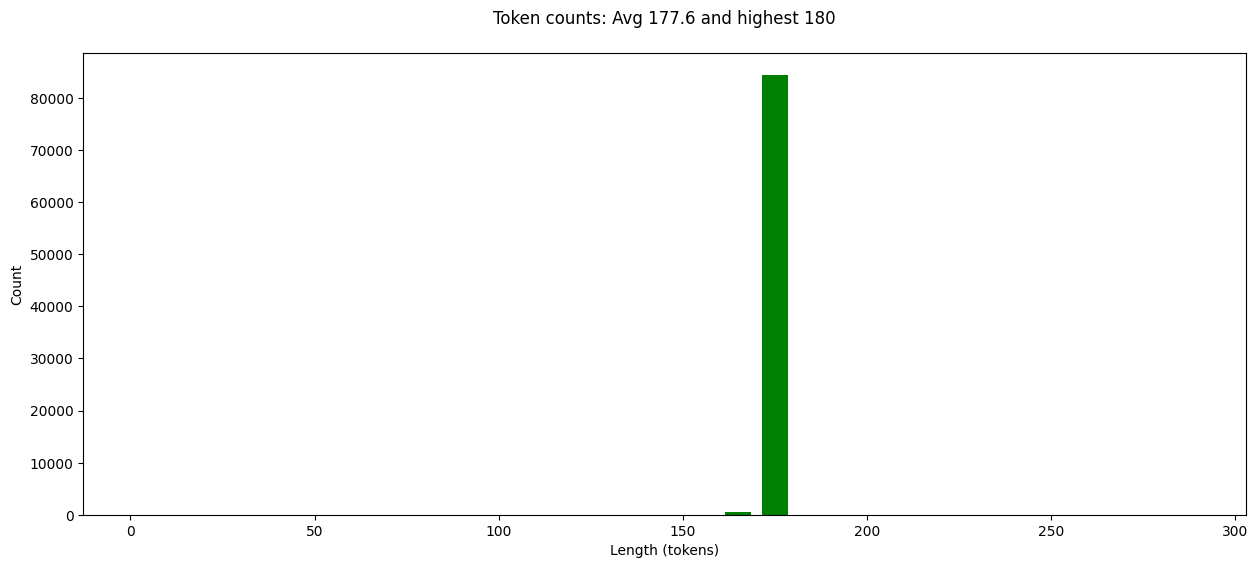

In [25]:
# Plot the distribution of token counts

tokens = [item.token_count for item in book_items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

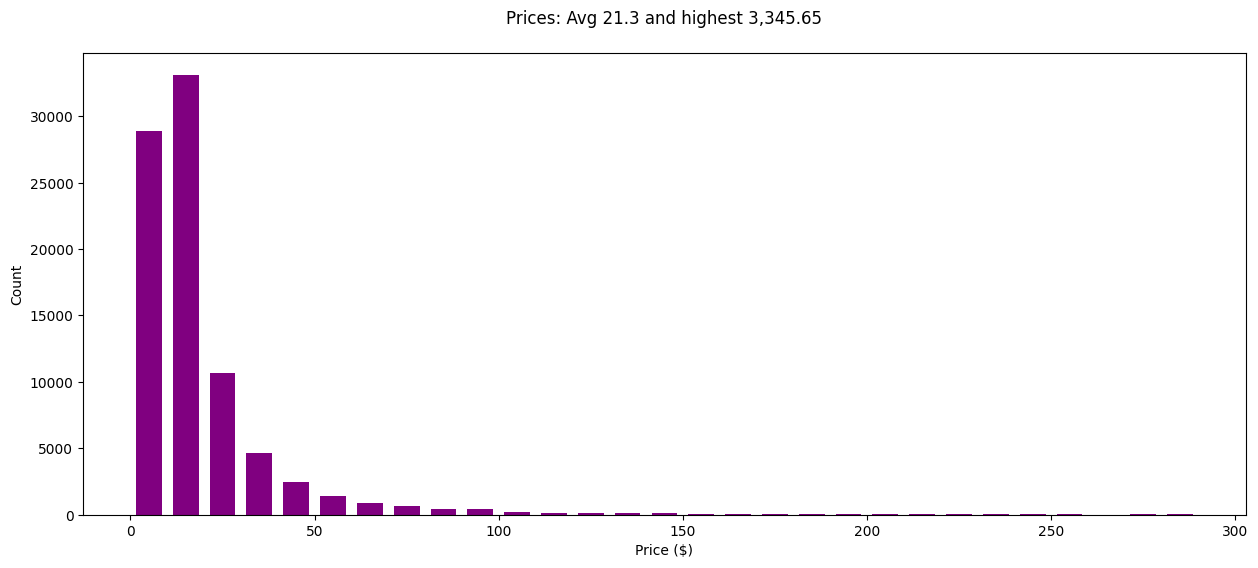

In [26]:
# Plot the distribution of prices

prices = [item.price for item in book_items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

# Bring my raw data

In [ ]:
from BookLoader import load_books_from_rawdata

book_items = load_books_from_rawdata(rawdata, workers=8)
print(f"✅ A grand total of {len(book_items):,} books")


 43%|████▎     | 1897/4449 [1:04:20<2:36:45,  3.69s/it]

In [ ]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(book_items[0].prompt) 

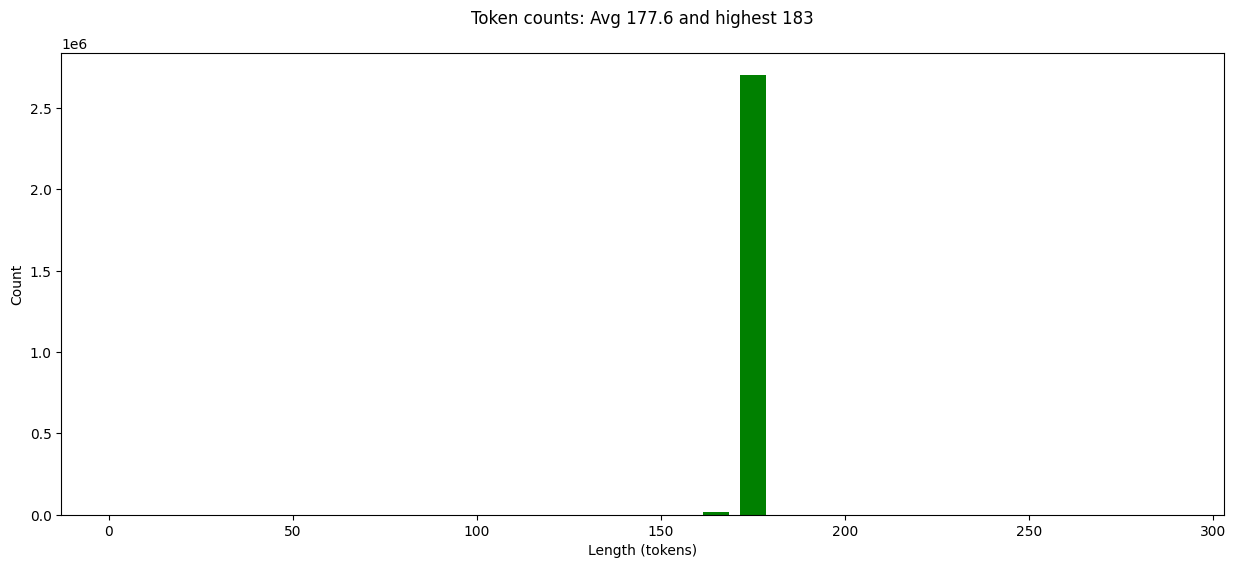

In [6]:
# Plot the distribution of token counts

tokens = [item.token_count for item in book_items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

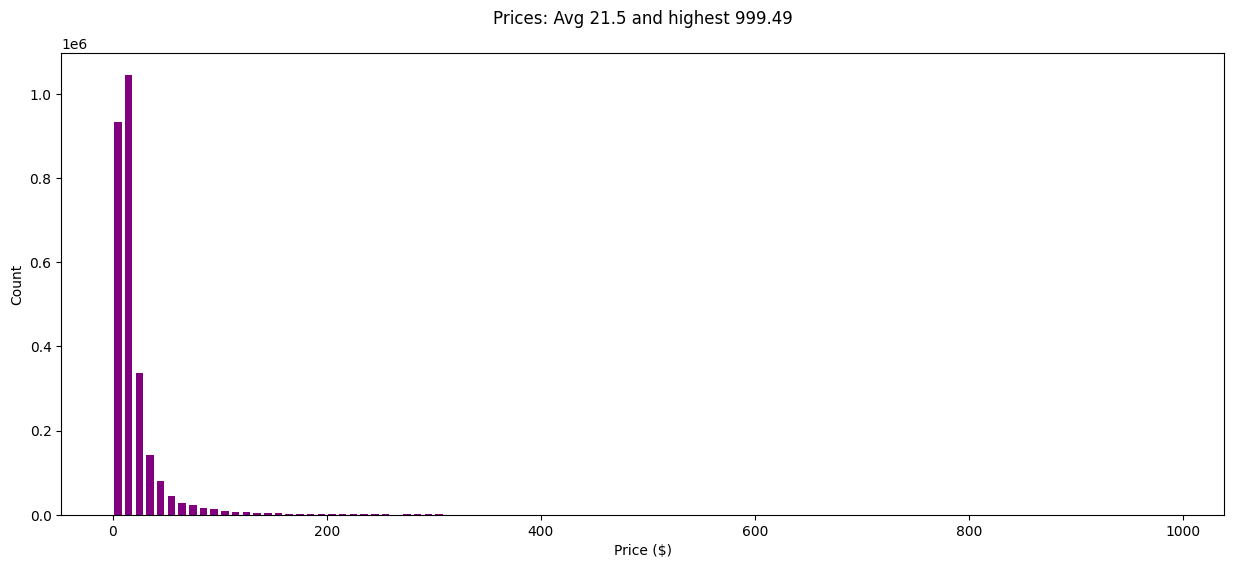

In [8]:
# Plot the distribution of prices

prices = [item.price for item in book_items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 1000, 10))
plt.show()

## sort data for more balance

In [7]:
from collections import defaultdict
import numpy as np
import random

# Step 1: Create a dict to hold items bucketed by rounded price
price_buckets = defaultdict(list)
for item in book_items:
    rounded_price = round(item.price)
    price_buckets[rounded_price].append(item)

# Step 2: Set random seeds for reproducibility
np.random.seed(123)
random.seed(123)

# Step 3: Sample from each bucket based on your logic
sample = []
for price in range(1, 1000):
    bucket = price_buckets[price]
    
    if price >= 50:
        sample.extend(bucket)
    elif len(bucket) <= 2000:
        sample.extend(bucket)
    else:
        selected_indices = np.random.choice(len(bucket), size=2000, replace=False)
        selected = [bucket[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")


There are 289,972 items in the sample


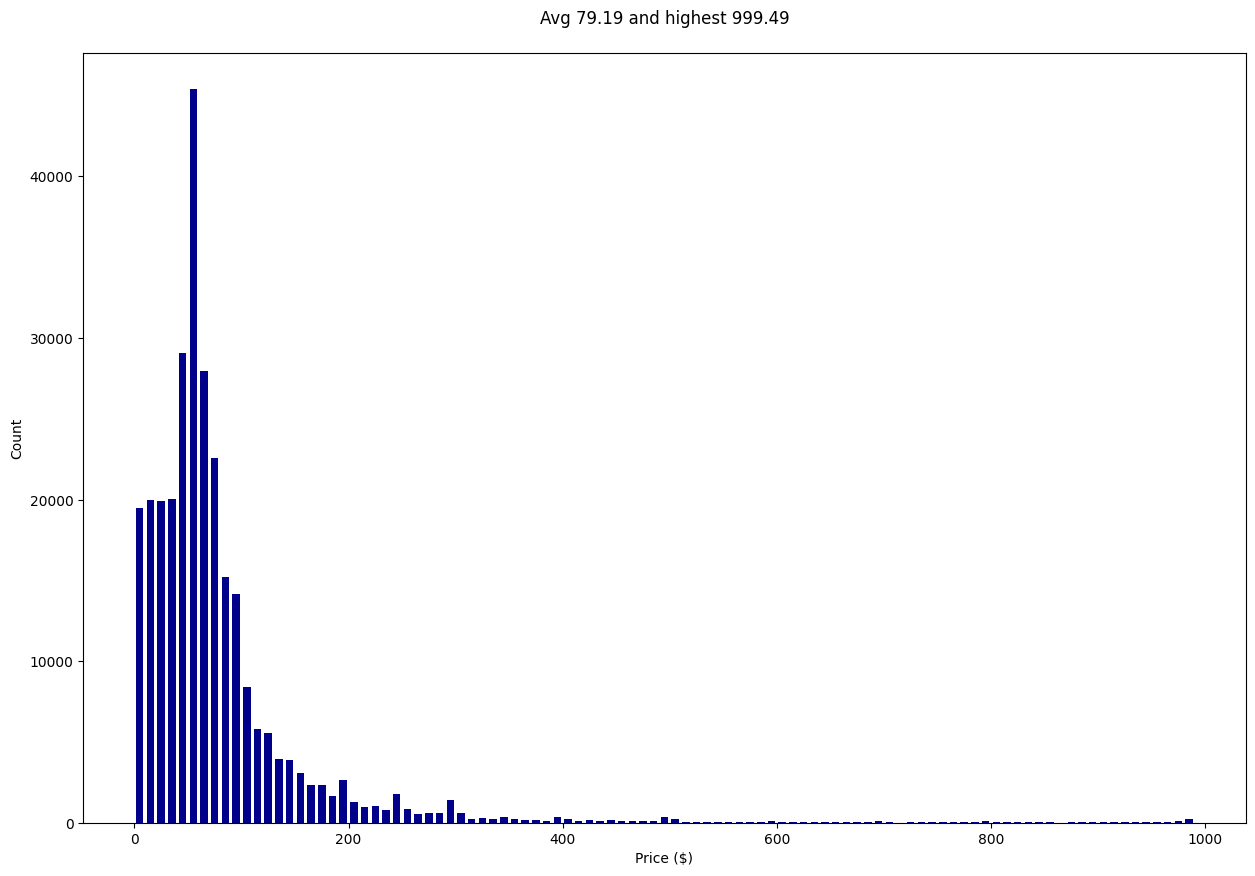

In [ ]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 5))
plt.show()

# Correlation

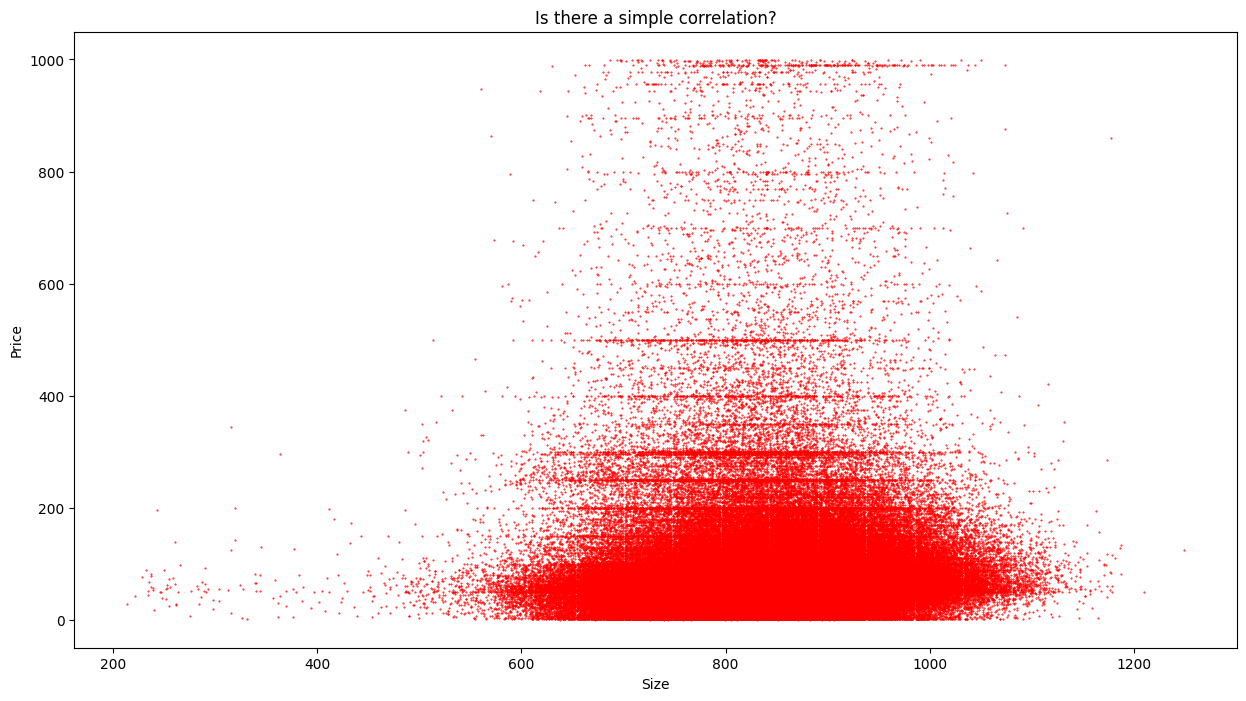

In [29]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

# Split dataset 

In [ ]:
random.seed(123)

# Shuffle full dataset
random.shuffle(sample)  

# Calculate split index
split_idx = int(0.9 * len(sample))  # 90% training

# Split into training and test sets
train = sample[:split_idx]
test = sample[split_idx:]

# Print result
print(f"Divided into a training set of {len(train):,} items and a test set of {len(test):,} items")


Divided into a training set of 260,974 items and a test set of 28,998 items


In [10]:
print(train[0].prompt)

How much does this book cost to the nearest dollar?

Extremely Weird Animal Defenses
Describes the physical characteristics and behavior of a number of animals with unusual means of defense, including the burrfish, the gelada, and the bulldog ant Publisher Rick Steves (April 16, 1997), Language English, Paperback 32 pages, ISBN 10 ISBN 13 Reading age 8 - 12 years, Grade level 3 - 7, Item Weight 4.8 ounces, Dimensions 8.5 x 0.25 x 11.5 inches Categories Books, Science & Math, Biological Sciences Author 'avatar' 'https 'name' 'Sarah Lovett', 'about' 'Discover more of the author’s books, see similar authors, read author blogs and more'

Price is $3.00


In [14]:
print(test[0].test_prompt())

How much does this book cost to the nearest dollar?

Successful with the Agile Spotify Framework Squads, Tribes and Chapters - The Next Step After Scrum and Kanban?
The so called Spotify Framework, unlike frameworks or methods of the kind of Scrum, Kanban, Less, Nexus, SAFe, DSDM (or whatever the agile evergreens might all be called) is not a template that an organization can copy and implement. It is an example of a very successful approach to the topic Agile Product Development and is intended to encourage people to think and develop on their own. That is exactly what the experienced agile consultant and coach Alvar Lundberg does in his book. He shows the elements of the Spotify framework, explains its background and shows the reader how he can approach his own agile implementation based on these considerations and insights. He does not

Price is $


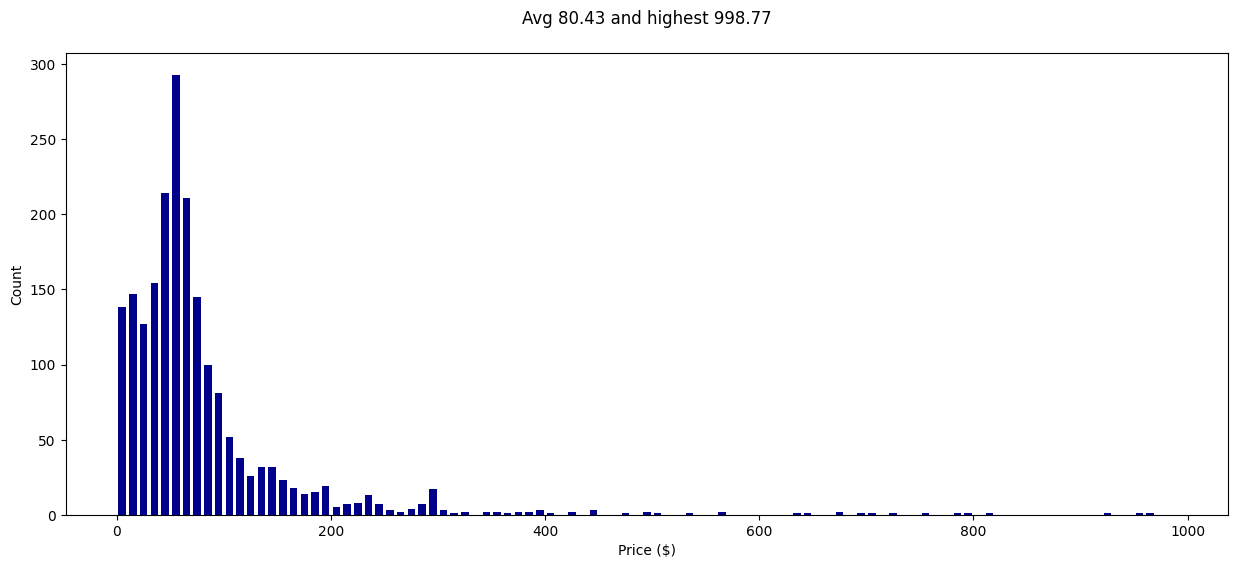

In [ ]:
# Plot the distribution of prices in the first 2000 test points

prices = [float(item.price) for item in test[:2000]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 5))
plt.show()

# Upload dataset to hugging face hub

In [23]:
# extract prompt and price
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]

test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [24]:
# Hugging face dataset
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
# bunddle
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [25]:
# upload to hugging face hub
HF_USER = "Timi1511"
DATASET_NAME = f"{HF_USER}/bookpricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards: 100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/Timi1511/bookpricer-data/commit/c3bc4d23e6069f24905049aae8444c0d1e8ccd52', commit_message='Upload dataset', commit_description='', oid='c3bc4d23e6069f24905049aae8444c0d1e8ccd52', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Timi1511/bookpricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Timi1511/bookpricer-data'), pr_revision=None, pr_num=None)

In [27]:
# write .pkl file for reuse
import pickle

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)


In [3]:
# open .pkl files from local
import pickle

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# Traditional ML

In [ ]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
# NLP related imports
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
# Finally, more imports for more advanced machine learning
from sklearn.ensemble import HistGradientBoostingRegressor

In [9]:
print(train[0].prompt)

How much does this book cost to the nearest dollar?

Extremely Weird Animal Defenses
Describes the physical characteristics and behavior of a number of animals with unusual means of defense, including the burrfish, the gelada, and the bulldog ant Publisher Rick Steves (April 16, 1997), Language English, Paperback 32 pages, ISBN 10 ISBN 13 Reading age 8 - 12 years, Grade level 3 - 7, Item Weight 4.8 ounces, Dimensions 8.5 x 0.25 x 11.5 inches Categories Books, Science & Math, Biological Sciences Author 'avatar' 'https 'name' 'Sarah Lovett', 'about' 'Discover more of the author’s books, see similar authors, read author blogs and more'

Price is $3.00


In [44]:
print(train[0].price)

3.2


## Random Price guesser

In [7]:
import random

def random_pricer(item):
    return random.randrange(1, 1000)

random.seed(123)

## Setup

In [8]:

import math
import matplotlib.pyplot as plt

# Assuming you have already loaded `test` data and set random seed
size = 300  # or any size <= len(test)
guesses = []
truths = []
errors = []
sles = []
colors = []

# Color codes for terminal output (optional)
def color_for(error, truth):
    if error < 40 or error / truth < 0.2:
        return "green"
    elif error < 80 or error / truth < 0.4:
        return "orange"
    else:
        return "red"


In [9]:
# Terminal color codes for output
COLOR_MAP = {
    "green": "\033[92m",   # Bright green
    "orange": "\033[93m",  # Yellow/orange
    "red": "\033[91m"      # Bright red
}
RESET = "\033[0m"  # Reset color

for i in range(size):
    datapoint = test[i]
    guess = random_pricer(datapoint)
    truth = datapoint.price
    error = abs(guess - truth)
    log_error = math.log(truth + 1) - math.log(guess + 1)
    sle = log_error ** 2
    color = color_for(error, truth)
    title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40] + "..."
    
    guesses.append(guess)
    truths.append(truth)
    errors.append(error)
    sles.append(sle)
    colors.append(color)

    # Print result
    print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")


1: Guess: $54.00 Truth: $35.50 Error: $18.50 SLE: 0.17 Item: Successful with the Agile Spotify Framew...
2: Guess: $275.00 Truth: $60.00 Error: $215.00 SLE: 2.28 Item: Handbook of Corporate Lending: A Guide f...
3: Guess: $90.00 Truth: $295.09 Error: $205.09 SLE: 1.39 Item: Grandes obras ilustradas de Charles Dick...
4: Guess: $788.00 Truth: $13.00 Error: $775.00 SLE: 16.25 Item: In Spite of the Storm: My Soul is Anchor...
5: Guess: $418.00 Truth: $9.63 Error: $408.37 SLE: 13.50 Item: Jesus Christ Heals
6: Guess: $273.00 Truth: $62.49 Error: $210.51 SLE: 2.14 Item: Romans (Ancient Christian Commentary on ...
7: Guess: $111.00 Truth: $29.97 Error: $81.03 SLE: 1.65 Item: Quality (5th Edition)
8: Guess: $859.00 Truth: $182.87 Error: $676.13 SLE: 2.38 Item: Giant Magnetoresistance (GMR) Sensors: F...
9: Guess: $923.00 Truth: $38.98 Error: $884.02 SLE: 9.86 Item: Secrets of Lighting on Location: A Photo...
10: Guess: $896.00 Truth: $42.80 Error: $853.20 SLE: 9.12 Item: Brand Elevation: Less

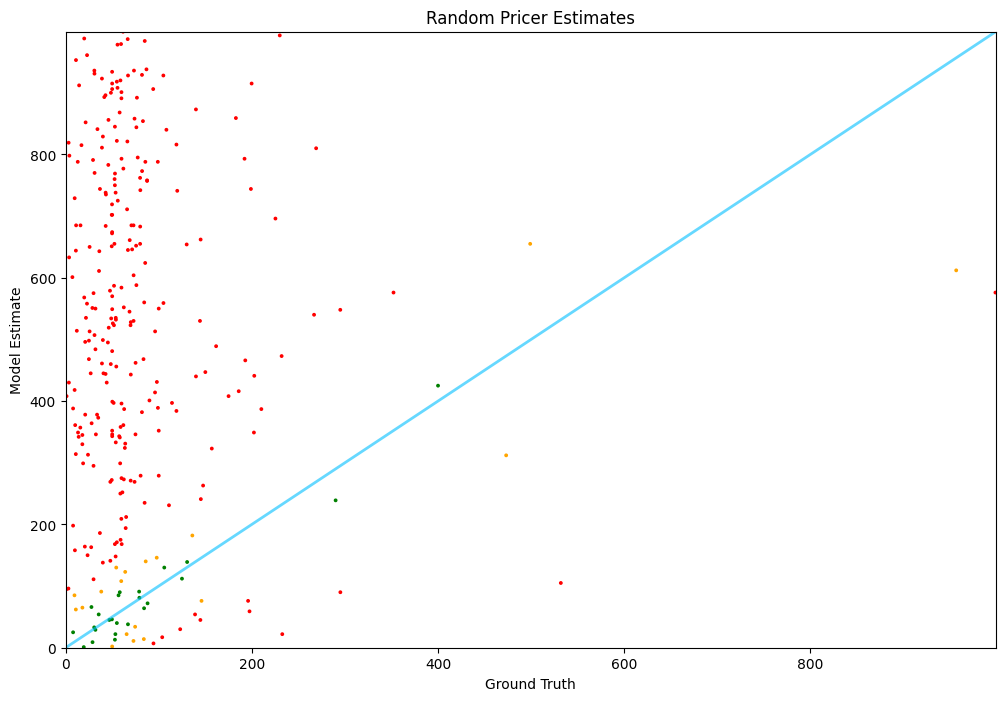

In [12]:
# visualization
max_val = max(max(truths), max(guesses))

plt.figure(figsize=(12, 8))
plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
plt.scatter(truths, guesses, s=3, c=colors)
plt.xlabel('Ground Truth')
plt.ylabel('Model Estimate')
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.title("Random Pricer Estimates")
plt.show()


In [11]:
average_error = sum(errors) / size
rmsle = math.sqrt(sum(sles) / size)
hits = sum(1 for c in colors if c == "green")
hit_rate = hits / size * 100

print(f"\nReport for Random Pricer")
print(f"Average Error: ${average_error:,.2f}")
print(f"RMSLE: {rmsle:.2f}")
print(f"Green Hit Rate: {hit_rate:.1f}%")



Report for Random Pricer
Average Error: $423.71
RMSLE: 2.29
Green Hit Rate: 8.0%


In [10]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=300):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error < 40 or error / truth < 0.2:
            return "green"
        elif error < 80 or error / truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth + 1) - math.log(guess + 1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40] + "..."

        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)

        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_val = max(max(self.truths), max(self.guesses))
        plt.figure(figsize=(12, 8))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color == "green")
        title = f"{self.title} | Avg Error = ${average_error:,.2f} | RMSLE = {rmsle:,.2f} | Hits = {hits / self.size * 100:.1f}%"
        self.chart(title)

    def run(self):
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()


1: Guess: $54.00 Truth: $35.50 Error: $18.50 SLE: 0.17 Item: Successful with the Agile Spotify Framew...
2: Guess: $275.00 Truth: $60.00 Error: $215.00 SLE: 2.28 Item: Handbook of Corporate Lending: A Guide f...
3: Guess: $90.00 Truth: $295.09 Error: $205.09 SLE: 1.39 Item: Grandes obras ilustradas de Charles Dick...
4: Guess: $788.00 Truth: $13.00 Error: $775.00 SLE: 16.25 Item: In Spite of the Storm: My Soul is Anchor...
5: Guess: $418.00 Truth: $9.63 Error: $408.37 SLE: 13.50 Item: Jesus Christ Heals
6: Guess: $273.00 Truth: $62.49 Error: $210.51 SLE: 2.14 Item: Romans (Ancient Christian Commentary on ...
7: Guess: $111.00 Truth: $29.97 Error: $81.03 SLE: 1.65 Item: Quality (5th Edition)
8: Guess: $859.00 Truth: $182.87 Error: $676.13 SLE: 2.38 Item: Giant Magnetoresistance (GMR) Sensors: F...
9: Guess: $923.00 Truth: $38.98 Error: $884.02 SLE: 9.86 Item: Secrets of Lighting on Location: A Photo...
10: Guess: $896.00 Truth: $42.80 Error: $853.20 SLE: 9.12 Item: Brand Elevation: Less

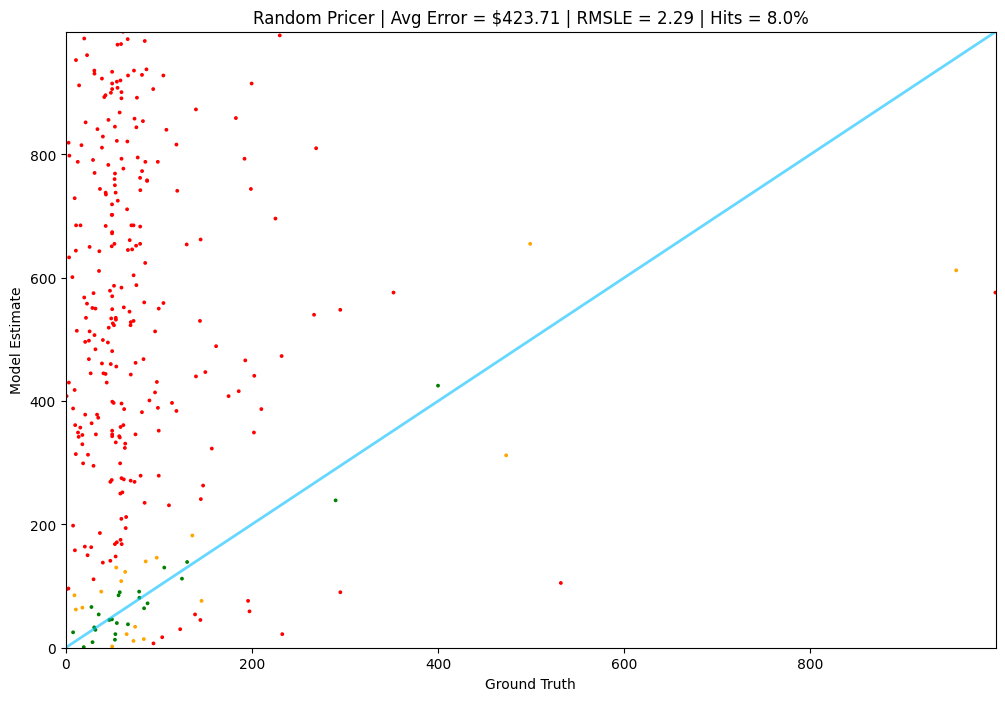

In [ ]:

# Run our TestRunner
random.seed(123)
Tester.test(random_pricer)

In [63]:
train[0].details

'{"Publisher": "Rick Steves (April 16, 1997)", "Language": "English", "Paperback": "32 pages", "ISBN 10": "1562613588", "ISBN 13": "978-1562613587", "Reading age": "8 - 12 years", "Grade level": "3 - 7", "Item Weight": "4.8 ounces", "Dimensions": "8.5 x 0.25 x 11.5 inches"}'

In [11]:
# Create a new "parsed_details" field on items, and populate it with json parsed from the details dict
import json

for item in train:
    item.parsed_details = json.loads(item.details)
for item in test:
    item.parsed_details = json.loads(item.details)

In [9]:
train[2].parsed_details

{'Publisher': 'School Zone Publishing (February 6, 2019)',
 'Language': 'English',
 'Mass Market Paperback': '224 pages',
 'ISBN 10': '1601599358',
 'ISBN 13': '978-1601599353',
 'Reading age': '3 - 6 years, from customers',
 'Grade level': '2 - 3',
 'Item Weight': '1.46 pounds',
 'Dimensions': '12 x 14.25 x 7.25 inches'}

In [25]:
train[0].parsed_details.keys()

dict_keys(['Publisher', 'Language', 'Paperback', 'ISBN 10', 'ISBN 13', 'Reading age', 'Grade level', 'Item Weight', 'Dimensions'])

In [12]:
# Look at 40 most common features in training set
from collections import Counter

parsed_details_count = Counter()
for item in train:
    for f in item.parsed_details.keys():
        parsed_details_count[f]+=1

parsed_details_count.most_common(40)

[('Publisher', 249153),
 ('Language', 249077),
 ('Item Weight', 241182),
 ('ISBN 13', 233333),
 ('ISBN 10', 229277),
 ('Dimensions', 215843),
 ('Paperback', 111716),
 ('Hardcover', 99600),
 ('Reading age', 21940),
 ('Grade level', 13693),
 ('Publication date', 9126),
 ('Lexile measure', 4881),
 ('Product Dimensions', 4846),
 ('Release date', 4698),
 ('Sticky notes', 4324),
 ('File size', 4323),
 ('Enhanced typesetting', 4323),
 ('Text to Speech', 4322),
 ('Word Wise', 4322),
 ('Print length', 4260),
 ('X Ray', 4172),
 ('Screen Reader', 3613),
 ('Mass Market Paperback', 2571),
 ('Spiral bound', 2038),
 ('Country of Origin', 1981),
 ('Loose Leaf', 1505),
 ('Simultaneous device usage', 1351),
 ('Perfect Paperback', 990),
 ('Library Binding', 941),
 ('Is Discontinued By Manufacturer', 803),
 ('Board book', 718),
 ('Audio CD', 638),
 ('Page numbers source ISBN', 626),
 ('Package Dimensions', 616),
 ('Cards', 536),
 ('Printed Access Code', 468),
 ('Leather Bound', 455),
 ('Imitation Leather'

In [13]:
# Item weight
def get_weight(item):
    weight_str = item.parsed_details.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [14]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [15]:
average_weight = sum(weights)/len(weights)
average_weight

1.9004274912415615

In [16]:
## item weight
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [17]:
import re

def convert_grade_level(grade_str):
    if not grade_str:
        return None

    grade_str = grade_str.strip().lower()

    if 'kindergarten' in grade_str:
        return 0
    elif 'college' in grade_str:
        return 13  # Or 14, depending on your definition
    elif 'all ages' in grade_str:
        return None  # or a default like 7
    elif 'and up' in grade_str:
        match = re.search(r'\d+', grade_str)
        if match:
            return int(match.group())
    elif '-' in grade_str:
        parts = re.findall(r'\d+', grade_str)
        if len(parts) == 2:
            return (int(parts[0]) + int(parts[1])) / 2
    elif grade_str.isdigit():
        return int(grade_str)

    return None


In [18]:
grades = [convert_grade_level(item.parsed_details.get("Grade level")) for item in train]
grades = [g for g in grades if g is not None]
average_grade = sum(grades) / len(grades)

## grade level
def get_grade_with_default(item):
    grade = convert_grade_level(item.parsed_details.get("Grade level"))
    return int(grade if grade is not None else average_grade)


In [25]:
average_grade

5.428822937625754

In [19]:
## text lenghth
def get_text_length(item):
    return len(item.test_prompt())

In [20]:
## publisher
##### extract publisher name
import re

def get_publisher_name(item):
    raw = item.parsed_details.get("Publisher")
    if not raw:
        return None

    # Remove everything after the first open parenthesis or semicolon
    raw = re.split(r'[\(;]', raw)[0].strip()
    
    return raw if raw else None


In [21]:
publishers = [get_publisher_name(item) for item in train]
publishers = [p for p in publishers if p]

In [ ]:
# investigate the publishers

publishers_count = Counter()
for t in train:
    publisher = t.parsed_details.get("Publisher")
    if publisher:
        publishers_count[publisher]+=1

# Look at most common 40 publishers

publishers_count.most_common(40)

[('Mometrix Media LLC; Flc Crds edition (February 14, 2013)', 186),
 ('Independently published', 175),
 ('Routledge; 1 edition', 137),
 ('Kessinger Publishing, LLC (September 10, 2010)', 133),
 ('CreateSpace Independent Publishing Platform', 121),
 ('Mometrix Media LLC (February 14, 2013)', 97),
 ('Forgotten Books (August 24, 2018)', 94),
 ('Kessinger Publishing, LLC (July 25, 2007)', 53),
 ('Wiley; 1 edition', 44),
 ('CRC Press; 1 edition', 43),
 ('Kessinger Publishing (September 10, 2010)', 43),
 ('Mometrix Media LLC; 1st edition (February 14, 2013)', 43),
 ('Mometrix Media LLC; Study Guide edition (February 14, 2013)', 40),
 ('Marvel Enterprises (January 1, 2010)', 38),
 ('Marvel Enterprises (January 1, 2012)', 38),
 ('Marvel Enterprises (January 1, 2009)', 36),
 ('Kessinger Publishing', 35),
 ('Cambridge University Press; 1 edition', 35),
 ('Oxford University Press', 34),
 ('Cambridge University Press', 34),
 ('Oxford University Press; 1 edition', 33),
 ('Kessinger Publishing, LLC 

In [23]:
from collections import Counter

top_publishers = set([k for k, v in Counter(publishers).items() if v > 20])
## publisher
def clean_publisher(p):
    if not p:
        return 'other'
    p = p.lower().strip()
    return p if p in top_publishers else 'other'


In [24]:
# publication year
def get_publication_year(item):
    pub_date = item.parsed_details.get("Publication date")
    if not pub_date:
        return None

    # Try to extract year using regex
    match = re.search(r'\b(19|20)\d{2}\b', pub_date)
    if match:
        return int(match.group())

    return None

# Compute average year for fallback
pub_years = [get_publication_year(item) for item in train]
pub_years = [y for y in pub_years if y is not None]
average_year = sum(pub_years) / len(pub_years)

def get_publication_year_with_default(item):
    year = get_publication_year(item)
    return int(year if year is not None else average_year)


In [ ]:
# print length
import re

def get_print_length(item):
    length_str = item.parsed_details.get("Print length")
    if length_str:
        match = re.search(r'\d+', length_str)
        if match:
            return int(match.group())
    return None

# Compute average for fallback
print_lengths = [get_print_length(item) for item in train]
print_lengths = [pl for pl in print_lengths if pl is not None]
average_print_length = sum(print_lengths) / len(print_lengths)

def get_print_length_with_default(item):
    length = get_print_length(item)
    return int(length if length is not None else average_print_length)


In [26]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "grade_level": get_grade_with_default(item),
        "text_length": get_text_length(item),
        "publisher": clean_publisher(get_publisher_name(item)),
        "publication_year": get_publication_year_with_default(item),
        "print_length": get_print_length_with_default(item),
    }


In [28]:
# Look at features in a training item
get_features(train[0])

{'weight': 0.3,
 'grade_level': 5,
 'text_length': 652,
 'publisher': 'other',
 'publication_year': 2011,
 'print_length': 449}

## convert to dataframe

In [29]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:300])

In [36]:
train_df.head()

,weight,grade_level,text_length,publisher,publication_year,print_length,price
0,0.300000,5,652,other,2011,449,3.20
1,0.002188,5,788,other,2011,449,53.97
2,1.460000,2,716,other,2011,449,17.99
3,0.881250,5,852,other,2011,449,67.50
4,3.550000,5,972,other,2011,449,57.36


In [30]:
from sklearn.preprocessing import OneHotEncoder

# Create OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit on both train and test to ensure alignment
ohe.fit(pd.concat([train_df[['publisher']], test_df[['publisher']]]))

# Transform train and test
train_encoded = ohe.transform(train_df[['publisher']])
test_encoded = ohe.transform(test_df[['publisher']])

# Get encoded column names
encoded_cols = ohe.get_feature_names_out(['publisher'])

# Convert to DataFrames
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_cols, index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_cols, index=test_df.index)

# Drop original publisher column
train_df = pd.concat([train_df.drop(columns=['publisher']), train_encoded_df], axis=1)
test_df = pd.concat([test_df.drop(columns=['publisher']), test_encoded_df], axis=1)


In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   weight                    300 non-null    float64
 1   grade_level               300 non-null    int64  
 2   text_length               300 non-null    int64  
 3   publication_year          300 non-null    int64  
 4   print_length              300 non-null    int64  
 5   price                     300 non-null    float64
 6   publisher_christianaudio  300 non-null    float64
 7   publisher_generic         300 non-null    float64
 8   publisher_gestalten       300 non-null    float64
 9   publisher_lulu.com        300 non-null    float64
 10  publisher_other           300 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 25.9 KB


# Traditional Linear Regression

In [32]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(123)

# Separate features and target
feature_columns = [col for col in train_df.columns if col != 'price']  # everything except target
X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Print coefficients
print("Feature coefficients:")
for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"\nIntercept: {model.intercept_:.4f}")

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")


Feature coefficients:
weight: 0.2046
grade_level: 0.8954
text_length: 0.0312
publication_year: -2.1081
print_length: 0.0127
publisher_christianaudio: 12.3928
publisher_generic: 5.1282
publisher_gestalten: 4.3933
publisher_lulu.com: -20.8442
publisher_other: -1.0701

Intercept: 4283.1280

Mean Squared Error: 10805.2599
R-squared Score: -0.0067


In [33]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    # Get features dictionary
    features_dict = get_features(item)
    
    # Convert to DataFrame (single row)
    features_df = pd.DataFrame([features_dict])
    
    # Apply one-hot encoding for publisher
    publisher_encoded = ohe.transform(features_df[['publisher']])
    publisher_encoded_df = pd.DataFrame(publisher_encoded, columns=encoded_cols)
    
    # Drop original publisher column and add encoded columns
    features_df = pd.concat([features_df.drop(columns=['publisher']), publisher_encoded_df], axis=1)
    
    # Ensure all feature columns from the model are present
    for col in feature_columns:
        if col not in features_df.columns:
            features_df[col] = 0
    
    # Select only the columns used by the model
    features_df = features_df[feature_columns]
    
    # Predict price
    return model.predict(features_df)[0]

1: Guess: $79.80 Truth: $35.50 Error: $44.30 SLE: 0.63 Item: Successful with the Agile Spotify Framew...
2: Guess: $80.00 Truth: $60.00 Error: $20.00 SLE: 0.08 Item: Handbook of Corporate Lending: A Guide f...
3: Guess: $74.17 Truth: $295.09 Error: $220.92 SLE: 1.88 Item: Grandes obras ilustradas de Charles Dick...
4: Guess: $76.08 Truth: $13.00 Error: $63.08 SLE: 2.91 Item: In Spite of the Storm: My Soul is Anchor...
5: Guess: $76.32 Truth: $9.63 Error: $66.69 SLE: 3.94 Item: Jesus Christ Heals
6: Guess: $95.29 Truth: $62.49 Error: $32.80 SLE: 0.17 Item: Romans (Ancient Christian Commentary on ...
7: Guess: $83.61 Truth: $29.97 Error: $53.64 SLE: 1.01 Item: Quality (5th Edition)
8: Guess: $80.92 Truth: $182.87 Error: $101.95 SLE: 0.65 Item: Giant Magnetoresistance (GMR) Sensors: F...
9: Guess: $82.83 Truth: $38.98 Error: $43.85 SLE: 0.55 Item: Secrets of Lighting on Location: A Photo...
10: Guess: $78.00 Truth: $42.80 Error: $35.20 SLE: 0.35 Item: Brand Elevation: Lessons in Ueber-Bra

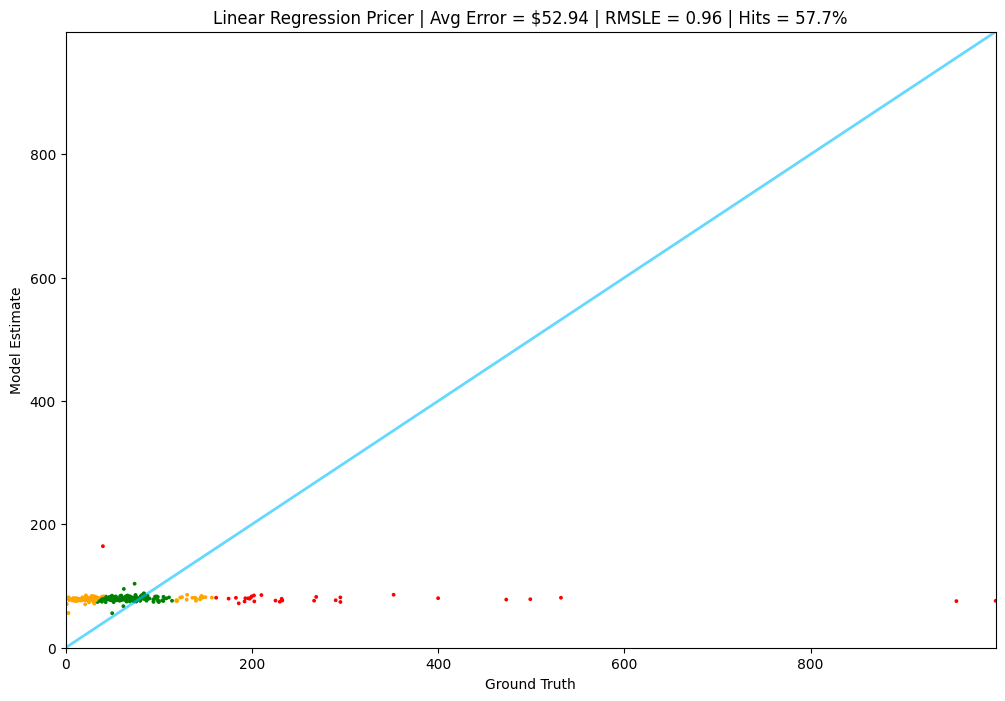

In [34]:
# test it
random.seed(123)
Tester.test(linear_regression_pricer)

# NLP

In [37]:
# For the next few models, we prepare our documents and prices

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [38]:
np.random.seed(123)
# Preprocess the documents for Word2Vec
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train the Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [39]:
# Convert documents to average Word2Vec embeddings
def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

1: Guess: $65.66 Truth: $35.50 Error: $30.16 SLE: 0.36 Item: Successful with the Agile Spotify Framew...
2: Guess: $90.52 Truth: $60.00 Error: $30.52 SLE: 0.16 Item: Handbook of Corporate Lending: A Guide f...
3: Guess: $101.79 Truth: $295.09 Error: $193.30 SLE: 1.12 Item: Grandes obras ilustradas de Charles Dick...
4: Guess: $62.49 Truth: $13.00 Error: $49.49 SLE: 2.29 Item: In Spite of the Storm: My Soul is Anchor...
5: Guess: $72.64 Truth: $9.63 Error: $63.01 SLE: 3.75 Item: Jesus Christ Heals
6: Guess: $78.76 Truth: $62.49 Error: $16.27 SLE: 0.05 Item: Romans (Ancient Christian Commentary on ...
7: Guess: $100.43 Truth: $29.97 Error: $70.46 SLE: 1.41 Item: Quality (5th Edition)
8: Guess: $100.30 Truth: $182.87 Error: $82.57 SLE: 0.36 Item: Giant Magnetoresistance (GMR) Sensors: F...
9: Guess: $96.82 Truth: $38.98 Error: $57.84 SLE: 0.80 Item: Secrets of Lighting on Location: A Photo...
10: Guess: $59.64 Truth: $42.80 Error: $16.84 SLE: 0.11 Item: Brand Elevation: Lessons in Ueber-B

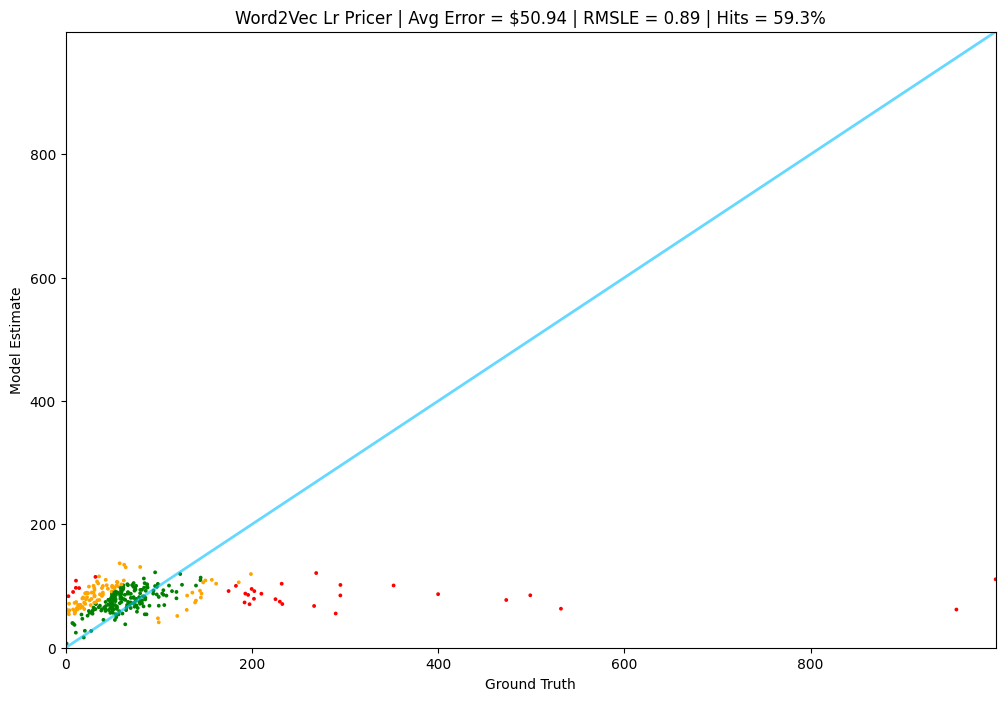

In [ ]:
# Run Linear Regression on word2vec, implementing gensim nlp

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])
Tester.test(word2vec_lr_pricer)

# HistGradientBoostingRegressor 

In [ ]:

hgbr_model = HistGradientBoostingRegressor(max_iter=100, random_state=123)
hgbr_model.fit(X_w2v, prices)

HistGradientBoostingRegressor(random_state=123)

In [36]:
def hgbr_pricer(item):
    doc_vector = document_vector(item.test_prompt())
    return max(0, hgbr_model.predict([doc_vector])[0])

1: Guess: $78.84 Truth: $35.50 Error: $43.34 SLE: 0.61 Item: Successful with the Agile Spotify Framew...
2: Guess: $82.39 Truth: $60.00 Error: $22.39 SLE: 0.10 Item: Handbook of Corporate Lending: A Guide f...
3: Guess: $102.10 Truth: $295.09 Error: $192.99 SLE: 1.11 Item: Grandes obras ilustradas de Charles Dick...
4: Guess: $57.12 Truth: $13.00 Error: $44.12 SLE: 2.03 Item: In Spite of the Storm: My Soul is Anchor...
5: Guess: $81.11 Truth: $9.63 Error: $71.48 SLE: 4.18 Item: Jesus Christ Heals
6: Guess: $73.78 Truth: $62.49 Error: $11.29 SLE: 0.03 Item: Romans (Ancient Christian Commentary on ...
7: Guess: $106.76 Truth: $29.97 Error: $76.79 SLE: 1.55 Item: Quality (5th Edition)
8: Guess: $99.37 Truth: $182.87 Error: $83.50 SLE: 0.37 Item: Giant Magnetoresistance (GMR) Sensors: F...
9: Guess: $80.81 Truth: $38.98 Error: $41.83 SLE: 0.51 Item: Secrets of Lighting on Location: A Photo...
10: Guess: $57.56 Truth: $42.80 Error: $14.76 SLE: 0.08 Item: Brand Elevation: Lessons in Ueber-Br

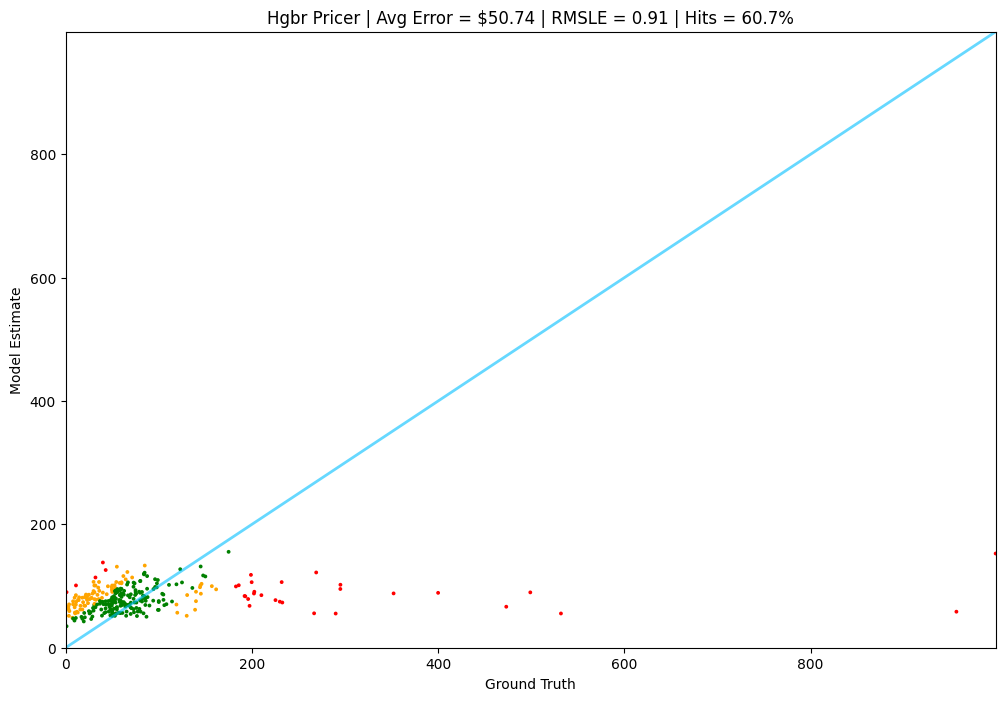

In [39]:
Tester.test(hgbr_pricer)